The main purpose of this notebook is to explore the dataset


In [42]:
#import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [43]:
# Load the dataset


# Define the base directory containing data files
base_dir = "/Users/dino/code/Obispodino/cvino/raw_data/X-Wines_Official_Repository/last"  # Updated to absolute path
wines_file = os.path.join(base_dir, "XWines_Full_100K_wines.csv")
wines_data = pd.read_csv(wines_file)
wd = wines_data
wd.head()

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201..."
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200..."
2,100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
3,100004,Virtus Moscato,White,Varietal/100%,['Muscat/Moscato'],['Sweet Dessert'],12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10003,Monte Paschoal,http://www.montepaschoal.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."
4,100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201..."


In [44]:
# !pip install geopy

In [46]:
import pandas as pd
import numpy as np
import pickle
import os
from pathlib import Path
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def geocode_regions(df, region_column='RegionName', cache_file='geocoding_cache.pkl', min_delay=1.0):
    """
    Geocode region names with caching and rate limiting

    Parameters:
        df (pd.DataFrame): Input DataFrame
        region_column (str): Name of region column
        cache_file (str): Path to cache file
        min_delay (float): Minimum delay between API requests (seconds)

    Returns:
        pd.DataFrame: DataFrame with latitude/longitude columns
    """
    # Initialize geocoder with rate limiter
    geolocator = Nominatim(user_agent="regional_analysis_app")
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=min_delay)

    # Load existing cache
    cache_path = Path(cache_file)
    if cache_path.exists():
        with open(cache_path, 'rb') as f:
            geocode_cache = pickle.load(f)
    else:
        geocode_cache = {}

    # Get unique regions needing geocoding
    unique_regions = df[region_column].dropna().unique()
    new_regions = [r for r in unique_regions if r not in geocode_cache]

    print(f"Found {len(unique_regions)} unique regions ({len(new_regions)} new)")

    # Geocode new regions with retry logic
    for region in new_regions:
        for attempt in range(3):  # 3 retry attempts
            try:
                location = geocode(region)
                geocode_cache[region] = {
                    'latitude': location.latitude if location else np.nan,
                    'longitude': location.longitude if location else np.nan
                }
                break
            except Exception as e:
                if attempt == 2:  # Final attempt failed
                    geocode_cache[region] = {'latitude': np.nan, 'longitude': np.nan}
                    print(f"Failed to geocode {region} after 3 attempts")
                continue

    # Save updated cache
    with open(cache_path, 'wb') as f:
        pickle.dump(geocode_cache, f)

    # Create coordinate columns
    df['latitude'] = df[region_column].map(lambda x: geocode_cache.get(x, {}).get('latitude'))
    df['longitude'] = df[region_column].map(lambda x: geocode_cache.get(x, {}).get('longitude'))

    return df #.drop(columns=[region_column])

# Usage
wd = geocode_regions(wd, min_delay=2.0)
print("Geocoding completed.")

# Identify rows where geocoding failed (latitude is null) after geocoding
not_found_df = wd[wd['latitude'].isnull()]

# Get a unique list of the region names that were not found
unresolved_regions = not_found_df['RegionName'].unique().tolist()

if unresolved_regions:
    print("The following regions could not be geocoded:")
    for region in unresolved_regions:
        print(f"- {region}")
else:
    print("All regions were successfully geocoded.")


Found 2160 unique regions (0 new)
Geocoding completed.
The following regions could not be geocoded:
- Maipo Valley
- Champagne Premier Cru
- Amarone della Valpolicella Classico
- Monção e Melgaço
- Malmsey Madeira
- Távora-Varosa
- Bual Madeira
- Sercial Madeira
- Verdelho Madeira
- Fino Sherry
- Oloroso Sherry
- Amontillado Sherry
- Curico Valley
- Rapel Valley
- Romania Viniculture
- Colli de Scandiano e Canosa
- Pessac-Léognan
- Saint-Émilion Grand Cru
- Côtes Catalanes
- Côtes du Roussillon Villages
- Champagne Grand Cru 'Chouilly'
- Southern Rhône
- Champagne Grand Cru 'Bouzy'
- Pouilly-Fumé
- Champagne Grand Cru 'Le Mesnil-sur-Oger'
- Bourgogne Hautes-Côtes de Beaune
- Castillon-Côtes de Bordeaux
- Lussac-Saint-Émilion
- Côtes de Thongue
- Coteaux Varois en Provence
- Côtes-du-Rhône-Villages 'Plan de Dieu'
- Champagne Grand Cru 'Ambonnay'
- Chablis 1er Cru 'Fourchaume'
- Blaye-Côtes de Bordeaux
- Champagne Grand Cru 'Aÿ'
- Cadillac-Côtes de Bordeaux
- Mercurey 1er Cru 'Clos des M

In [ ]:
wd.head(25)


In [47]:
# Drop the rows where latitude is null
wd = wd.dropna(subset=['latitude', 'longitude'])
wd.head(25)

,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages,latitude,longitude
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201...",-29.163142,-51.495526
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200...",-29.163142,-51.495526
2,100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526
3,100004,Virtus Moscato,White,Varietal/100%,['Muscat/Moscato'],['Sweet Dessert'],12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10003,Monte Paschoal,http://www.montepaschoal.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526
4,100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526
5,100006,Reserva Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.5,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526
6,100007,Do Lugar Moscatel Espumantes,Sparkling,Varietal/100%,['Muscat/Moscato Bianco'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10012,Dal Pizzol,http://www.dalpizzol.com.br,"[2018, 2017, 2016, 2015, 2014, 2013, 2012, 201...",-29.163142,-51.495526
7,100008,Paradoxo Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",13.5,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10011,Salton,http://www.salton.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526
8,100009,Seleção Cabernet Sauvignon-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",12.5,Full-bodied,High,BR,Brazil,1004,Campanha Gaúcha,10013,Miolo,http://www.miolo.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-23.537176,-46.416807
9,100010,Defesa Tinto,Red,Assemblage/Blend,"['Touriga Nacional', 'Syrah/Shiraz']","['Beef', 'Lamb', 'Veal', 'Poultry']",14.0,Full-bodied,High,PT,Portugal,1038,Alentejano,12039,Esporão,http://www.esporao.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-22.905677,-43.176343


In [49]:
wd.info()


<class 'pandas.core.frame.DataFrame'>
Index: 92042 entries, 0 to 100645
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   WineID      92042 non-null  int64  
 1   WineName    92042 non-null  object 
 2   Type        92042 non-null  object 
 3   Elaborate   92042 non-null  object 
 4   Grapes      92042 non-null  object 
 5   Harmonize   92042 non-null  object 
 6   ABV         92042 non-null  float64
 7   Body        92042 non-null  object 
 8   Acidity     92042 non-null  object 
 9   Code        92042 non-null  object 
 10  Country     92042 non-null  object 
 11  RegionID    92042 non-null  int64  
 12  RegionName  92042 non-null  object 
 13  WineryID    92042 non-null  int64  
 14  WineryName  92042 non-null  object 
 15  Website     76035 non-null  object 
 16  Vintages    92042 non-null  object 
 17  latitude    92042 non-null  float64
 18  longitude   92042 non-null  float64
dtypes: float64(3), int64(3), obje

Total number of wines: 92042
Number of unique countries: 61
Number of unique wineries: 28188


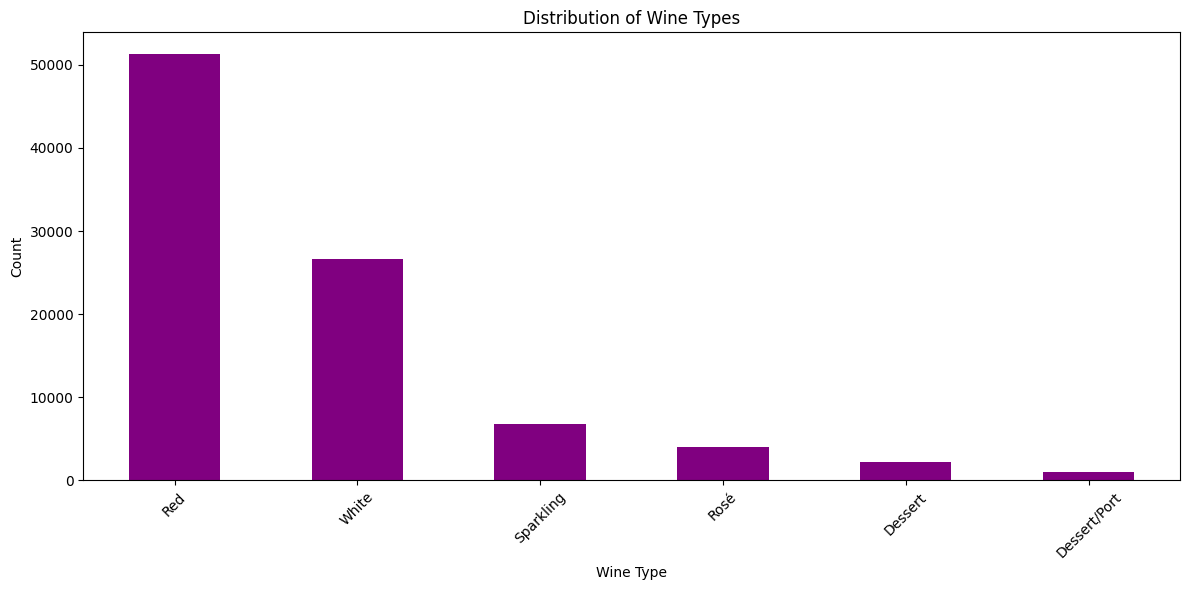

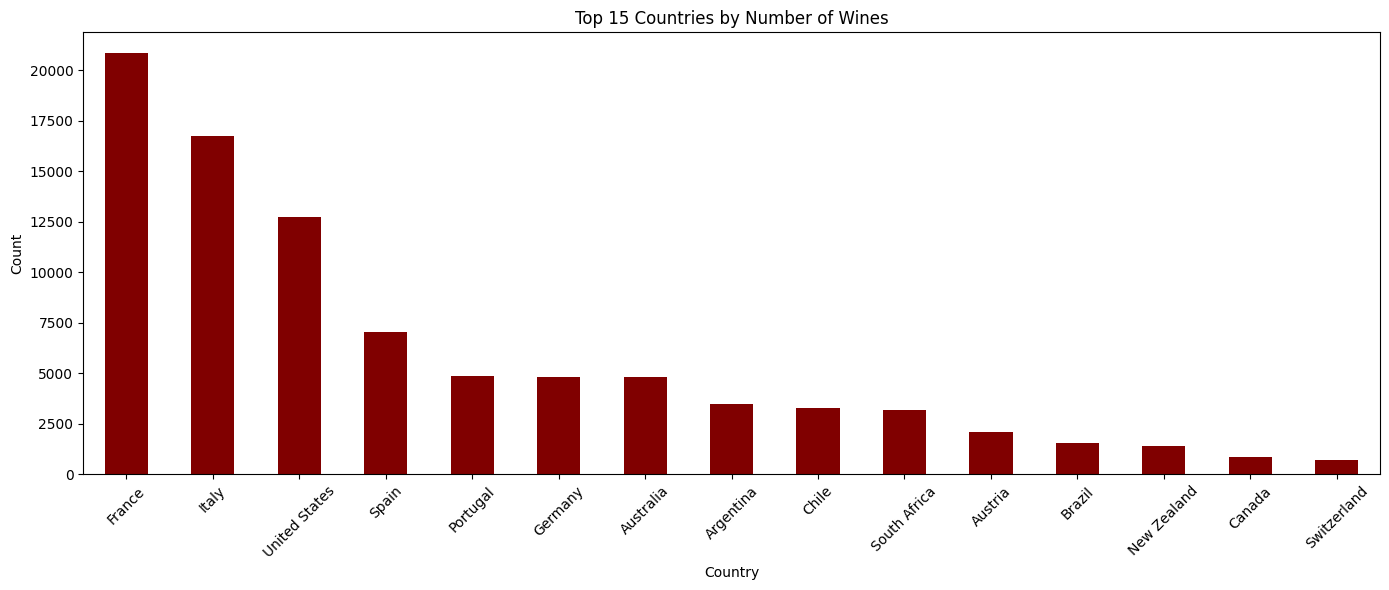

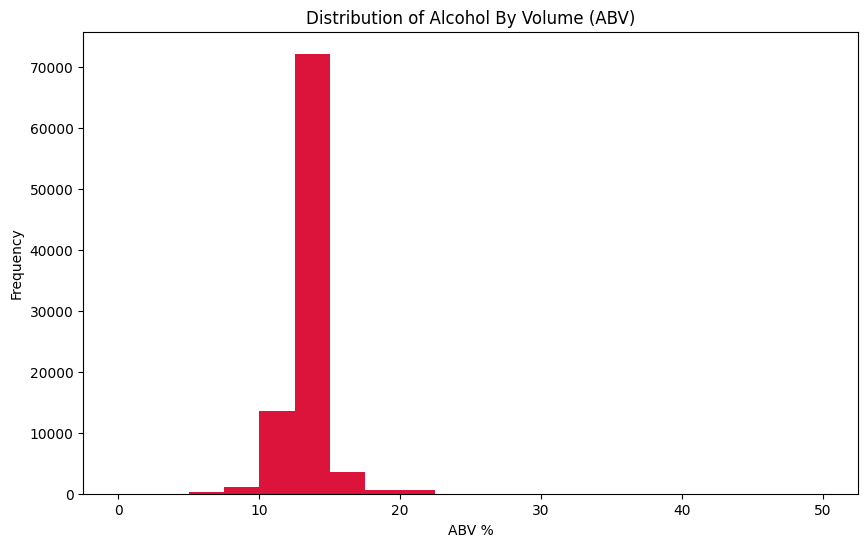

/var/folders/2k/f80hp_x95nz3w249z8ch76fc0000gn/T/ipykernel_63384/266594966.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd['Grapes_list'] = wd['Grapes'].apply(lambda x: eval(x) if isinstance(x, str) else x)


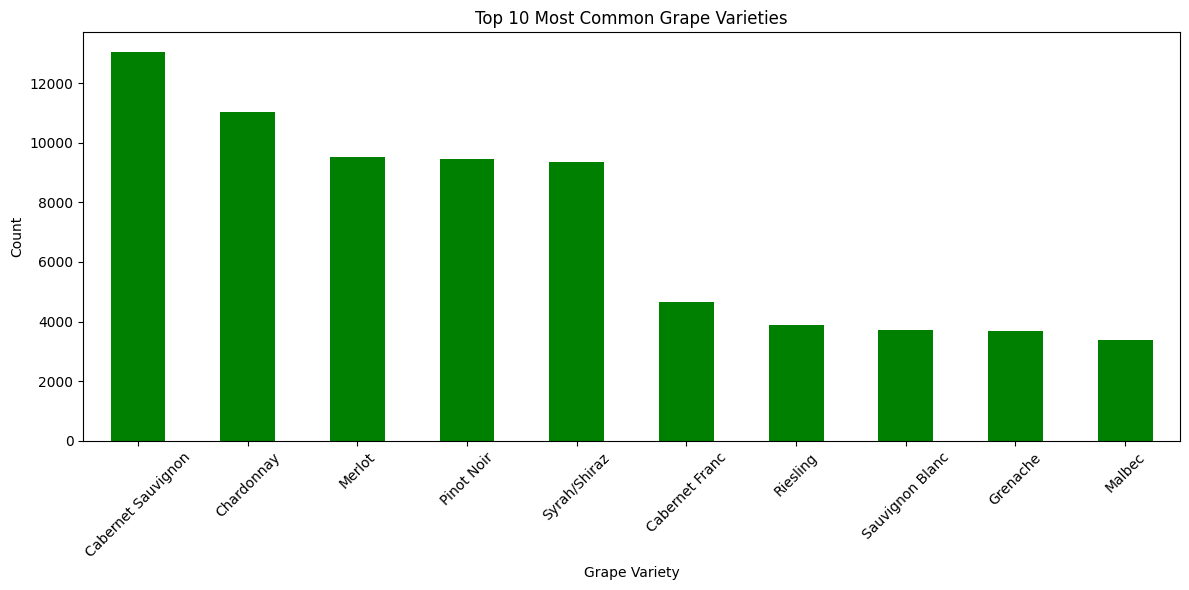

In [50]:
# Explore the wines dataset

# Basic information about the dataset
print(f"Total number of wines: {len(wd)}")
print(f"Number of unique countries: {wd['Country'].nunique()}")

print(f"Number of unique wineries: {wd['WineryName'].nunique()}")

# Distribution of wine types
plt.figure(figsize=(12, 6))
type_counts = wd['Type'].value_counts()
type_counts.plot(kind='bar', color='purple')
plt.title('Distribution of Wine Types')
plt.xlabel('Wine Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution of wines by country (top 15)
plt.figure(figsize=(14, 6))
country_counts = wd['Country'].value_counts().head(15)
country_counts.plot(kind='bar', color='maroon')
plt.title('Top 15 Countries by Number of Wines')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ABV distribution
plt.figure(figsize=(10, 6))
wd['ABV'].hist(bins=20, color='crimson')
plt.title('Distribution of Alcohol By Volume (ABV)')
plt.xlabel('ABV %')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Convert string lists to actual lists for analysis
# Example with Grapes column
wd['Grapes_list'] = wd['Grapes'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Top 10 most common grape varieties
all_grapes = [grape for sublist in wd['Grapes_list'] for grape in sublist]
grape_counts = pd.Series(all_grapes).value_counts().head(10)

plt.figure(figsize=(12, 6))
grape_counts.plot(kind='bar', color='green')
plt.title('Top 10 Most Common Grape Varieties')
plt.xlabel('Grape Variety')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [51]:
# Load the ratings dataset
ratingstxt = "XWines_Full_21M_ratings.csv"
ratings_file = os.path.join(base_dir, ratingstxt)
ratings = pd.read_csv(ratings_file)
ratings.head()

/var/folders/2k/f80hp_x95nz3w249z8ch76fc0000gn/T/ipykernel_63384/3398277075.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings = pd.read_csv(ratings_file)


,RatingID,UserID,WineID,Vintage,Rating,Date
0,1,1604441,136103,1950,4.0,2019-10-14 11:20:52
1,2,1291483,136103,1950,5.0,2019-11-28 03:36:33
2,3,1070605,104036,1950,5.0,2017-12-28 10:15:55
3,4,1080181,144864,1950,5.0,2016-06-23 02:16:22
4,5,1834379,111430,1950,5.0,2021-05-16 17:58:14


In [52]:
ratings.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21013536 entries, 0 to 21013535
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   RatingID  int64  
 1   UserID    int64  
 2   WineID    int64  
 3   Vintage   object 
 4   Rating    float64
 5   Date      object 
dtypes: float64(1), int64(3), object(2)
memory usage: 961.9+ MB


In [53]:
# DATA CLEANING STAGE - Step 1: Assess Data Quality
print("=== DATA QUALITY ASSESSMENT ===")
print("\n1. WINES DATASET:")
print(f"Shape: {wd.shape}")
print(f"Missing values per column:")
print(wd.isnull().sum())
# Create a copy without list columns for duplicate checking
wd_for_dup_check = wd.drop(columns=['Grapes_list'])
print(f"\nDuplicate rows: {wd_for_dup_check.duplicated().sum()}")

print("\n2. RATINGS DATASET:")
print(f"Shape: {ratings.shape}")
print(f"Missing values per column:")
print(ratings.isnull().sum())
print(f"\nDuplicate rows: {ratings.duplicated().sum()}")

# Check data types
print("\n3. WINES DATA TYPES:")
print(wd.dtypes)

=== DATA QUALITY ASSESSMENT ===

1. WINES DATASET:
Shape: (92042, 20)
Missing values per column:
WineID             0
WineName           0
Type               0
Elaborate          0
Grapes             0
Harmonize          0
ABV                0
Body               0
Acidity            0
Code               0
Country            0
RegionID           0
RegionName         0
WineryID           0
WineryName         0
Website        16007
Vintages           0
latitude           0
longitude          0
Grapes_list        0
dtype: int64

Duplicate rows: 0

2. RATINGS DATASET:
Shape: (21013536, 6)
Missing values per column:
RatingID    0
UserID      0
WineID      0
Vintage     0
Rating      0
Date        0
dtype: int64

Duplicate rows: 0

3. WINES DATA TYPES:
WineID           int64
WineName        object
Type            object
Elaborate       object
Grapes          object
Harmonize       object
ABV            float64
Body            object
Acidity         object
Code            object
Country       

In [54]:
# DATA CLEANING STAGE - Step 2: Clean Wine Dataset
print("=== CLEANING WINES DATASET ===")

# Create a clean copy
wines_clean = wd.copy()

# 1. Handle missing values
print("Handling missing values...")
# Drop rows with missing essential information
wines_clean = wines_clean.dropna(subset=['WineName', 'Country', 'Type'])

# Fill missing ABV with median by wine type
wines_clean['ABV'] = wines_clean.groupby('Type')['ABV'].transform(lambda x: x.fillna(x.median()))

# Fill missing RegionName with 'Unknown'
# wines_clean['RegionName'] = wines_clean['RegionName'].fillna('Unknown')

# Fill missing WineryName with 'Unknown'
wines_clean['WineryName'] = wines_clean['WineryName'].fillna('Unknown')

print(f"Rows after cleaning: {len(wines_clean)} (removed {len(wd) - len(wines_clean)} rows)")

# 2. Standardize text fields
print("Standardizing text fields...")
wines_clean['Country'] = wines_clean['Country'].str.strip()
wines_clean['Type'] = wines_clean['Type'].str.strip()
wines_clean['WineName'] = wines_clean['WineName'].str.strip()

# 3. Handle list columns (Grapes, Harmonize, etc.)
print("Processing list columns...")
import ast

def safe_eval(x):
    """Safely evaluate string representations of lists"""
    try:
        if isinstance(x, str):
            return ast.literal_eval(x)
        return x if isinstance(x, list) else []
    except:
        return []

# Apply to list columns
# list_columns = ['Grapes', 'Harmonize', 'Elaborate', 'ABV', 'Body', 'Acidity']
# for col in list_columns:
#     if col in wines_clean.columns:
#         wines_clean[f'{col}_list'] = wines_clean[col].apply(safe_eval)

print("Wine dataset cleaning completed!")

=== CLEANING WINES DATASET ===
Handling missing values...
Rows after cleaning: 92042 (removed 0 rows)
Standardizing text fields...
Processing list columns...
Wine dataset cleaning completed!


In [55]:
# DATA CLEANING STAGE - Step 3: Clean Ratings Dataset
print("=== CLEANING RATINGS DATASET ===")

# Create a clean copy
ratings_clean = ratings.copy()

# 1. Remove invalid ratings
print("Removing invalid ratings...")
initial_count = len(ratings_clean)

# Remove ratings outside valid range (assuming 1-5 scale)
ratings_clean = ratings_clean[(ratings_clean['Rating'] >= 1) & (ratings_clean['Rating'] <= 5)]

# Remove entries with missing UserID or WineID
ratings_clean = ratings_clean.dropna(subset=['UserID', 'WineID'])

print(f"Ratings after cleaning: {len(ratings_clean)} (removed {initial_count - len(ratings_clean)} invalid ratings)")

# 2. Filter ratings for wines that exist in our clean wine dataset
print("Filtering ratings for existing wines...")
valid_wine_ids = set(wines_clean['WineID'])
ratings_clean = ratings_clean[ratings_clean['WineID'].isin(valid_wine_ids)]

print(f"Ratings after filtering: {len(ratings_clean)}")

print("Ratings dataset cleaning completed!")

=== CLEANING RATINGS DATASET ===
Removing invalid ratings...
Ratings after cleaning: 21013536 (removed 0 invalid ratings)
Filtering ratings for existing wines...
Ratings after filtering: 19167461
Ratings dataset cleaning completed!


In [ ]:
# feature selection, before encoding, drop: Elaborate, Code, Country, RegionID, WyneryID, Website, vintages, WineryName
wd.head(25)

# WineID is a label, lets drop it and some more...
wd = wd.drop(columns=['WineID', 'Elaborate', 'Code', 'Country', 'RegionID', 'WineryID', 'Website', 'vintages', 'WineryName'])


,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,Country,RegionID,RegionName,WineryID,WineryName,Website,Vintages,latitude,longitude,Grapes_list
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2020, 2019, 2018, 2017, 2016, 2015, 2014, 201...",-29.163142,-51.495526,[Muscat/Moscato]
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10001,Casa Perini,http://www.vinicolaperini.com.br,"[2016, 2015, 2014, 2013, 2012, 2011, 2010, 200...",-29.163142,-51.495526,[Ancellotta]
2,100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10002,Castellamare,https://www.emporiocastellamare.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526,[Cabernet Sauvignon]
3,100004,Virtus Moscato,White,Varietal/100%,['Muscat/Moscato'],['Sweet Dessert'],12.0,Medium-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10003,Monte Paschoal,http://www.montepaschoal.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526,[Muscat/Moscato]
4,100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526,"[Cabernet Sauvignon, Merlot]"
5,100006,Reserva Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.5,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10000,Aurora,http://www.vinicolaaurora.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526,[Cabernet Sauvignon]
6,100007,Do Lugar Moscatel Espumantes,Sparkling,Varietal/100%,['Muscat/Moscato Bianco'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,Brazil,1001,Serra Gaúcha,10012,Dal Pizzol,http://www.dalpizzol.com.br,"[2018, 2017, 2016, 2015, 2014, 2013, 2012, 201...",-29.163142,-51.495526,[Muscat/Moscato Bianco]
7,100008,Paradoxo Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",13.5,Full-bodied,High,BR,Brazil,1001,Serra Gaúcha,10011,Salton,http://www.salton.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-29.163142,-51.495526,[Cabernet Sauvignon]
8,100009,Seleção Cabernet Sauvignon-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",12.5,Full-bodied,High,BR,Brazil,1004,Campanha Gaúcha,10013,Miolo,http://www.miolo.com.br,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-23.537176,-46.416807,"[Cabernet Sauvignon, Merlot]"
9,100010,Defesa Tinto,Red,Assemblage/Blend,"['Touriga Nacional', 'Syrah/Shiraz']","['Beef', 'Lamb', 'Veal', 'Poultry']",14.0,Full-bodied,High,PT,Portugal,1038,Alentejano,12039,Esporão,http://www.esporao.com,"[2021, 2020, 2019, 2018, 2017, 2016, 2015, 201...",-22.905677,-43.176343,"[Touriga Nacional, Syrah/Shiraz]"


In [64]:
# DATA CLEANING STAGE - Step 4: Prepare Features for k-NN Model
print("=== PREPARING FEATURES FOR k-NN MODEL ===")

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
import pandas as pd
import numpy as np
from scipy.sparse import hstack

# Create feature matrix
features_df = wines_clean.copy()

# 1. Process categorical variables
print("Processing categorical variables...")

# a. OneHotEncode Type column
print("- One-hot encoding wine types...")
type_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
type_encoded = type_encoder.fit_transform(features_df[['Type']])
type_columns = [f'Type_{cat}' for cat in type_encoder.categories_[0]]
type_df = pd.DataFrame(type_encoded, columns=type_columns, index=features_df.index)

# b. Process Grapes (extract top N grapes)
print("- Processing grape varieties...")
N_TOP_GRAPES = 20  # Consider top 20 grape varieties

# Get most common grape varieties
all_grapes = [grape for sublist in features_df['Grapes_list'] for grape in sublist if isinstance(sublist, list)]
top_grapes = pd.Series(all_grapes).value_counts().head(N_TOP_GRAPES).index.tolist()

# Create binary columns for each top grape
for grape in top_grapes:
    features_df[f'Grape_{grape}'] = features_df['Grapes_list'].apply(
        lambda x: 1 if isinstance(x, list) and grape in x else 0
    )

grape_columns = [f'Grape_{grape}' for grape in top_grapes]

# c. Ordinal encode Body and Acidity
print("- Ordinal encoding Body and Acidity...")
# Define the order for Body
body_categories = ['Very light-bodied', 'Light-bodied', 'Medium-bodied', 'Full-bodied', 'Very full-bodied']
body_encoder = OrdinalEncoder(categories=[body_categories])
features_df['Body_encoded'] = np.nan
body_mask = features_df['Body'].isin(body_categories)
if body_mask.any():
    features_df.loc[body_mask, 'Body_encoded'] = body_encoder.fit_transform(
        features_df.loc[body_mask, ['Body']])
features_df['Body_encoded'] = features_df['Body_encoded'].fillna(2)  # Default to medium-bodied

# Define the order for Acidity
acidity_categories = ['Low', 'Medium', 'High']
acidity_encoder = OrdinalEncoder(categories=[acidity_categories])
features_df['Acidity_encoded'] = np.nan
acidity_mask = features_df['Acidity'].isin(acidity_categories)
if acidity_mask.any():
    features_df.loc[acidity_mask, 'Acidity_encoded'] = acidity_encoder.fit_transform(
        features_df.loc[acidity_mask, ['Acidity']])
features_df['Acidity_encoded'] = features_df['Acidity_encoded'].fillna(1)  # Default to medium acidity

# 2. Handle numerical features
print("Processing numerical features...")
# Ensure ABV is numeric
features_df['ABV_numeric'] = pd.to_numeric(features_df['ABV'], errors='coerce')
features_df['ABV_numeric'] = features_df['ABV_numeric'].fillna(features_df['ABV_numeric'].median())

# Keep latitude and longitude as is (they're already numeric)
numeric_columns = ['ABV_numeric', 'latitude', 'longitude']

# 3. Create wine profile features from aggregated ratings
print("Creating wine profile features...")
wine_stats = ratings_clean.groupby('WineID').agg({
    'Rating': ['mean', 'count', 'std']
}).round(2)

wine_stats.columns = ['avg_rating', 'rating_count', 'rating_std']
wine_stats = wine_stats.fillna(0)

# Merge with wine features
features_df = features_df.merge(wine_stats, left_on='WineID', right_index=True, how='left')
features_df[['avg_rating', 'rating_count', 'rating_std']] = features_df[['avg_rating', 'rating_count', 'rating_std']].fillna(0)
rating_columns = ['avg_rating', 'rating_count', 'rating_std']

# 4. Select final feature columns for k-NN
print("Compiling final feature set...")
# Combine all feature columns
feature_columns = numeric_columns + ['Body_encoded', 'Acidity_encoded'] + rating_columns + grape_columns
feature_dfs = [features_df[feature_columns], type_df]

# Create final feature matrix
X = pd.concat(feature_dfs, axis=1)

# 5. Scale features
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=features_df.index)

print(f"Feature matrix shape: {X_scaled_df.shape}")
print(f"Feature columns: {len(X_scaled_df.columns)} columns")
print("\nFeature matrix ready for k-NN model!")

# Update the feature_columns variable to include all columns
feature_columns = X_scaled_df.columns.tolist()

=== PREPARING FEATURES FOR k-NN MODEL ===
Processing categorical variables...
- One-hot encoding wine types...
- Processing grape varieties...
- Ordinal encoding Body and Acidity...
Processing numerical features...
Creating wine profile features...
Compiling final feature set...
Scaling features...
Feature matrix shape: (92042, 34)
Feature columns: 34 columns

Feature matrix ready for k-NN model!


In [65]:
# Extract unique categories from Body and Acidity columns

# acidity_categories = ['Low', 'Medium', 'High']  # Filter out non-string categories
# body_categories = ['Very light-bodied', 'Light-bodied', 'Medium-bodied', 'Full-bodied', 'Very full-bodied']  # Filter out non-string categories

print(acidity_categories)
print(body_categories)
features_df.head()


['Low', 'Medium', 'High']
['Very light-bodied', 'Light-bodied', 'Medium-bodied', 'Full-bodied', 'Very full-bodied']


,WineID,WineName,Type,Elaborate,Grapes,Harmonize,ABV,Body,Acidity,Code,...,Grape_Zinfandel,Grape_Viognier,Grape_Tinta Roriz,Grape_Touriga Franca,Body_encoded,Acidity_encoded,ABV_numeric,avg_rating,rating_count,rating_std
0,100001,Espumante Moscatel,Sparkling,Varietal/100%,['Muscat/Moscato'],"['Pork', 'Rich Fish', 'Shellfish']",7.5,Medium-bodied,High,BR,...,0,0,0,0,2.0,2.0,7.5,4.13,2625,0.74
1,100002,Ancellotta,Red,Varietal/100%,['Ancellotta'],"['Beef', 'Barbecue', 'Codfish', 'Pasta', 'Pizz...",12.0,Medium-bodied,Medium,BR,...,0,0,0,0,2.0,1.0,12.0,3.50,10,1.00
2,100003,Cabernet Sauvignon,Red,Varietal/100%,['Cabernet Sauvignon'],"['Beef', 'Lamb', 'Poultry']",12.0,Full-bodied,High,BR,...,0,0,0,0,3.0,2.0,12.0,3.38,62,0.71
3,100004,Virtus Moscato,White,Varietal/100%,['Muscat/Moscato'],['Sweet Dessert'],12.0,Medium-bodied,Medium,BR,...,0,0,0,0,2.0,1.0,12.0,3.17,110,0.81
4,100005,Maison de Ville Cabernet-Merlot,Red,Assemblage/Bordeaux Red Blend,"['Cabernet Sauvignon', 'Merlot']","['Beef', 'Lamb', 'Game Meat', 'Poultry']",11.0,Full-bodied,Medium,BR,...,0,0,0,0,3.0,1.0,11.0,2.97,72,0.97


In [66]:
# DATA CLEANING STAGE - Step 5: Build k-NN Model
print("=== BUILDING k-NN RECOMMENDATION MODEL ===")

from sklearn.neighbors import NearestNeighbors
import joblib

# 1. Initialize and train k-NN model
print("Training k-NN model...")
knn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')  # 6 to get 5 recommendations (excluding self)
knn_model.fit(X_scaled_df)

# 2. Create recommendation function
def get_wine_recommendations(wine_id, n_recommendations=5):
    """Get wine recommendations based on k-NN similarity"""
    try:
        # Find the index of the wine
        wine_idx = features_df[features_df['WineID'] == wine_id].index[0]

        # Get the wine's feature vector
        wine_features = X_scaled_df.loc[wine_idx].values.reshape(1, -1)

        # Find similar wines
        distances, indices = knn_model.kneighbors(wine_features, n_neighbors=n_recommendations+1)

        # Get recommended wine IDs (excluding the input wine itself)
        recommended_indices = indices[0][1:]  # Skip the first one (itself)
        recommended_wine_ids = features_df.iloc[recommended_indices]['WineID'].tolist()

        return recommended_wine_ids, distances[0][1:]
    except IndexError:
        return [], []

# 3. Test the model
print("Testing k-NN model...")
test_wine_id = features_df['WineID'].iloc[0]  # Use first wine as test
recommendations, distances = get_wine_recommendations(test_wine_id)

print(f"Test wine ID: {test_wine_id}")
print(f"Recommended wine IDs: {recommendations}")
print(f"Distances: {distances}")

# Display test results
if recommendations:
    test_wine_info = features_df[features_df['WineID'] == test_wine_id][['WineName', 'Country', 'Type']].iloc[0]
    print(f"\nOriginal wine: {test_wine_info['WineName']} ({test_wine_info['Country']}, {test_wine_info['Type']})")

    print("\nRecommended wines:")
    for i, rec_id in enumerate(recommendations):
        rec_info = features_df[features_df['WineID'] == rec_id][['WineName', 'Country', 'Type']].iloc[0]
        print(f"{i+1}. {rec_info['WineName']} ({rec_info['Country']}, {rec_info['Type']}) - Distance: {distances[i]:.3f}")

print("\nk-NN model successfully built and tested!")

=== BUILDING k-NN RECOMMENDATION MODEL ===
Training k-NN model...
Testing k-NN model...
Test wine ID: 100001
Recommended wine IDs: [100061, 100065, 100073, 136166, 136063]
Distances: [0.05460313 0.07271892 0.10401606 0.11867444 0.12119575]

Original wine: Espumante Moscatel (Brazil, Sparkling)

Recommended wines:
1. Moscatel (Brazil, Sparkling) - Distance: 0.055
2. Moscatel Espumante (Brazil, Sparkling) - Distance: 0.073
3. Moscatel (Brazil, Sparkling) - Distance: 0.104
4. Moscato d'Asti (Italy, Sparkling) - Distance: 0.119
5. Asti (Italy, Sparkling) - Distance: 0.121

k-NN model successfully built and tested!


/Users/dino/.pyenv/versions/3.10.6/envs/cvino/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [67]:
# DATA CLEANING STAGE - Step 6: Save Cleaned Data and Model
print("=== SAVING CLEANED DATA AND MODEL ===")

import os
import joblib

# Create data directory if it doesn't exist
data_dir = "/Users/dino/code/Obispodino/cvino/data"
os.makedirs(data_dir, exist_ok=True)

# 1. Save cleaned datasets
print("Saving cleaned datasets...")
wines_clean.to_csv(os.path.join(data_dir, 'wines_clean.csv'), index=False)
ratings_clean.to_csv(os.path.join(data_dir, 'ratings_clean.csv'), index=False)
features_df.to_csv(os.path.join(data_dir, 'wine_features.csv'), index=False)

# 2. Save the trained model and preprocessing objects
print("Saving k-NN model and preprocessing objects...")
model_data = {
    'knn_model': knn_model,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'wine_features': features_df
}

joblib.dump(model_data, os.path.join(data_dir, 'wine_recommendation_model.joblib'))

print("All data and model files saved successfully!")
print("\nFiles created:")
print(f"- {data_dir}/wines_clean.csv")
print(f"- {data_dir}/ratings_clean.csv")
print(f"- {data_dir}/wine_features.csv")
print(f"- {data_dir}/wine_recommendation_model.joblib")

print("\n=== DATA CLEANING STAGE COMPLETED ===")
print("Ready to proceed with backend development!")

=== SAVING CLEANED DATA AND MODEL ===
Saving cleaned datasets...
Saving k-NN model and preprocessing objects...
All data and model files saved successfully!

Files created:
- /Users/dino/code/Obispodino/cvino/data/wines_clean.csv
- /Users/dino/code/Obispodino/cvino/data/ratings_clean.csv
- /Users/dino/code/Obispodino/cvino/data/wine_features.csv
- /Users/dino/code/Obispodino/cvino/data/wine_recommendation_model.joblib

=== DATA CLEANING STAGE COMPLETED ===
Ready to proceed with backend development!


In [68]:
# Print a comprehensive summary of the wine recommendation model

print("=== WINE RECOMMENDATION MODEL SUMMARY ===\n")

# 1. Model Overview
print("MODEL OVERVIEW:")
print(f"- Type: k-Nearest Neighbors (k-NN)")
print(f"- Algorithm: {knn_model.algorithm}")
print(f"- Distance metric: {knn_model.metric}")
print(f"- Number of neighbors: {knn_model.n_neighbors}")
print(f"- Total wines in dataset: {len(features_df)}")

# 2. Feature Information
print("\nFEATURE INFORMATION:")
print(f"- Number of features: {len(feature_columns)}")
print("- Features used:")
for col in feature_columns:
    print(f"  • {col}")

# 3. Dataset Statistics
print("\nDATASET STATISTICS:")
print(f"- Total unique countries: {features_df['Country'].nunique()}")
print(f"- Total unique wine types: {features_df['Type'].nunique()}")
print(f"- Total unique regions: {features_df['RegionName'].nunique()}")
print(f"- Total unique wineries: {features_df['WineryName'].nunique()}")
print(f"- Average rating across all wines: {features_df['avg_rating'].mean():.2f}")
print(f"- Average number of ratings per wine: {features_df['rating_count'].mean():.2f}")

# 4. Wine Type Distribution
type_dist = features_df['Type'].value_counts()
print("\nWINE TYPE DISTRIBUTION:")
for wine_type, count in type_dist.items():
    print(f"- {wine_type}: {count} wines ({count/len(features_df)*100:.1f}%)")

# 5. Model Usage Example
print("\nMODEL USAGE EXAMPLE:")
print("To get wine recommendations:")
print("```python")
print("wine_id = 100001  # Example wine ID")
print("recommendations, distances = get_wine_recommendations(wine_id, n_recommendations=5)")
print("```")

print("\nRECOMMENDATION METHODOLOGY:")
print("1. The model uses cosine similarity to find wines with similar characteristics")
print("2. Features are scaled to ensure equal importance")
print("3. Categorical variables are encoded to numerical values")
print("4. Wine profile features combine intrinsic characteristics with user ratings")
print("5. The model returns the most similar wines based on these features")

print("\n=== END OF MODEL SUMMARY ===")

=== WINE RECOMMENDATION MODEL SUMMARY ===

MODEL OVERVIEW:
- Type: k-Nearest Neighbors (k-NN)
- Algorithm: brute
- Distance metric: cosine
- Number of neighbors: 6
- Total wines in dataset: 92042

FEATURE INFORMATION:
- Number of features: 34
- Features used:
  • ABV_numeric
  • latitude
  • longitude
  • Body_encoded
  • Acidity_encoded
  • avg_rating
  • rating_count
  • rating_std
  • Grape_Cabernet Sauvignon
  • Grape_Chardonnay
  • Grape_Merlot
  • Grape_Pinot Noir
  • Grape_Syrah/Shiraz
  • Grape_Cabernet Franc
  • Grape_Riesling
  • Grape_Sauvignon Blanc
  • Grape_Grenache
  • Grape_Malbec
  • Grape_Sangiovese
  • Grape_Tempranillo
  • Grape_Touriga Nacional
  • Grape_Mourvedre
  • Grape_Petit Verdot
  • Grape_Nebbiolo
  • Grape_Zinfandel
  • Grape_Viognier
  • Grape_Tinta Roriz
  • Grape_Touriga Franca
  • Type_Dessert
  • Type_Dessert/Port
  • Type_Red
  • Type_Rosé
  • Type_Sparkling
  • Type_White

DATASET STATISTICS:
- Total unique countries: 61
- Total unique wine types: 6

In [ ]:
# ...existing code...
# DATA CLEANING STAGE - Step 5: Build k-NN Model
# ...existing code...
print("\nk-NN model successfully built and tested!")

# CELL FOR EVALUATION SETUP
print("\n=== MODEL EVALUATION SETUP ===")
import random
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import numpy as np
import pandas as pd

# Ensure features_df has WineID as a readily accessible column and is indexed appropriately
# If WineID is not the index, set it for easy lookup if needed, or ensure efficient filtering.
# For this example, we'll assume features_df can be filtered by WineID easily.

def get_wine_details(wine_id_list):
    """Helper function to get details for a list of wine IDs."""
    if not wine_id_list:
        return pd.DataFrame()
    return features_df[features_df['WineID'].isin(wine_id_list)][['WineID', 'WineName', 'Country', 'Type', 'RegionName', 'Body', 'Acidity', 'Grapes_list', 'avg_rating']]

def jaccard_similarity(list1, list2):
    """Calculates Jaccard similarity between two lists."""
    if not isinstance(list1, list) or not isinstance(list2, list):
        return 0.0
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0.0

print("Evaluation helper functions defined.")

In [ ]:
# CELL FOR ENHANCED QUALITATIVE ANALYSIS
print("\n=== ENHANCED QUALITATIVE ANALYSIS ===")

# Select a diverse set of test_wine_ids
# Example: choose a few randomly, or pick specific ones based on characteristics
num_test_wines_qualitative = 5
if len(features_df) >= num_test_wines_qualitative:
    # Ensure we have 'WineID' column in features_df
    if 'WineID' in features_df.columns:
        sample_wine_ids = random.sample(features_df['WineID'].tolist(), min(num_test_wines_qualitative, len(features_df)))
    else:
        print("Error: 'WineID' column not found in features_df.")
        sample_wine_ids = []
else:
    sample_wine_ids = features_df['WineID'].tolist() if 'WineID' in features_df.columns else []


for test_id in sample_wine_ids:
    print(f"\n--- Qualitative Test for WineID: {test_id} ---")
    original_wine_info = get_wine_details([test_id])
    if original_wine_info.empty:
        print("Original wine not found.")
        continue

    print("\nOriginal Wine:")
    print(original_wine_info.to_string())

    recommendations, distances = get_wine_recommendations(test_id, n_recommendations=5)

    if recommendations:
        print("\nRecommended Wines:")
        recommended_wines_info = get_wine_details(recommendations)
        for i, rec_id in enumerate(recommendations):
            rec_info_row = recommended_wines_info[recommended_wines_info['WineID'] == rec_id]
            print(f"\n{i+1}. WineID: {rec_id} (Distance: {distances[i]:.4f})")
            print(rec_info_row.to_string())
    else:
        print("No recommendations found.")
    print("-" * 50)

In [ ]:
# CELL FOR QUANTITATIVE FEATURE AGREEMENT & SIMILARITY
print("\n=== QUANTITATIVE FEATURE AGREEMENT & SIMILARITY ===")

def evaluate_recommendation_features(input_wine_id, recommended_ids):
    if not recommended_ids:
        return None

    input_wine_details = features_df[features_df['WineID'] == input_wine_id].iloc[0]
    recommended_wines_details = features_df[features_df['WineID'].isin(recommended_ids)]

    metrics = {
        'type_match_percentage': 0,
        'country_match_percentage': 0,
        'avg_body_diff': np.nan, # Using encoded body for difference
        'avg_acidity_diff': np.nan, # Using encoded acidity for difference
        'avg_grape_jaccard': 0
    }

    type_matches = 0
    country_matches = 0
    body_diffs = []
    acidity_diffs = []
    grape_jaccards = []

    # Get encoded values for body and acidity for the input wine
    # Ensure 'Body_encoded' and 'Acidity_encoded' exist from Step 4
    input_body_encoded = input_wine_details.get('Body_encoded', np.nan)
    input_acidity_encoded = input_wine_details.get('Acidity_encoded', np.nan)

    for _, rec_wine in recommended_wines_details.iterrows():
        if rec_wine['Type'] == input_wine_details['Type']:
            type_matches += 1
        if rec_wine['Country'] == input_wine_details['Country']:
            country_matches += 1

        rec_body_encoded = rec_wine.get('Body_encoded', np.nan)
        rec_acidity_encoded = rec_wine.get('Acidity_encoded', np.nan)

        if not np.isnan(input_body_encoded) and not np.isnan(rec_body_encoded):
            body_diffs.append(abs(rec_body_encoded - input_body_encoded))
        if not np.isnan(input_acidity_encoded) and not np.isnan(rec_acidity_encoded):
            acidity_diffs.append(abs(rec_acidity_encoded - input_acidity_encoded))

        grape_jaccards.append(jaccard_similarity(input_wine_details['Grapes_list'], rec_wine['Grapes_list']))

    num_recommendations = len(recommended_ids)
    metrics['type_match_percentage'] = (type_matches / num_recommendations) * 100
    metrics['country_match_percentage'] = (country_matches / num_recommendations) * 100
    if body_diffs:
        metrics['avg_body_diff'] = np.mean(body_diffs)
    if acidity_diffs:
        metrics['avg_acidity_diff'] = np.mean(acidity_diffs)
    if grape_jaccards:
        metrics['avg_grape_jaccard'] = np.mean(grape_jaccards)

    return metrics

# Test with a sample of wines
num_test_wines_quantitative = 10
all_feature_eval_metrics = []

if len(features_df) >= num_test_wines_quantitative:
    if 'WineID' in features_df.columns:
        quantitative_sample_ids = random.sample(features_df['WineID'].tolist(), min(num_test_wines_quantitative, len(features_df)))
    else:
        print("Error: 'WineID' column not found in features_df for quantitative test.")
        quantitative_sample_ids = []
else:
    quantitative_sample_ids = features_df['WineID'].tolist() if 'WineID' in features_df.columns else []


for test_id in quantitative_sample_ids:
    recommendations, _ = get_wine_recommendations(test_id, n_recommendations=5)
    if recommendations:
        eval_metrics = evaluate_recommendation_features(test_id, recommendations)
        if eval_metrics:
            eval_metrics['input_wine_id'] = test_id
            all_feature_eval_metrics.append(eval_metrics)
            # print(f"Metrics for WineID {test_id}: {eval_metrics}")


if all_feature_eval_metrics:
    feature_eval_summary_df = pd.DataFrame(all_feature_eval_metrics)
    print("\n--- Feature Agreement & Similarity Summary ---")
    print(feature_eval_summary_df.mean(numeric_only=True)) # Display average metrics
    # print("\nDetailed Metrics per Wine:")
    # print(feature_eval_summary_df.to_string())
else:
    print("No quantitative feature evaluation metrics to display.")